# MLP
MLP, K=5, epochs=200.
Use lncRNA.
Train set: filter none.
Valid set: filter none.
Longest transcript per gene.

In [1]:
from datetime import datetime
print(datetime.now())

2023-04-04 13:44:58.072911


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.longest_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.longest_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.longest_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-04 13:45:24.881685
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65664     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-04 13:45:25.152338
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.longest_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-04-04 13:45:40.484269

Training # 1 1
2023-04-04 13:45:40.485536
2023-04-04 13:45:40.485596
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-04-04 13:45:40.538351


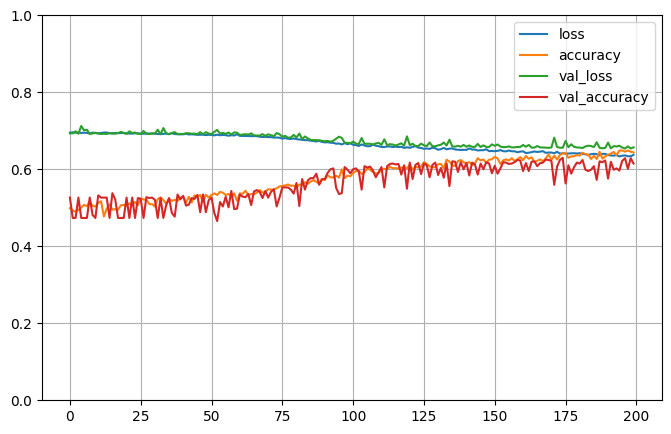


2023-04-04 13:47:03.576217

Testing # 1 1
2023-04-04 13:47:03.576818
2023-04-04 13:47:03.576894
PREDICT
2023-04-04 13:47:03.581907
Test 1:0 458:412 52.64%
Predict 1:0 631:239 72.53%
Test sizes (870, 1025) (870,)
Range of scores: 0.041448306 to 0.92667603
Score threshold 0.5
Confusion matrix
 [[158 254]
 [ 81 377]]
Normalized matrix
 [[0.1816092  0.29195402]
 [0.09310345 0.43333333]]


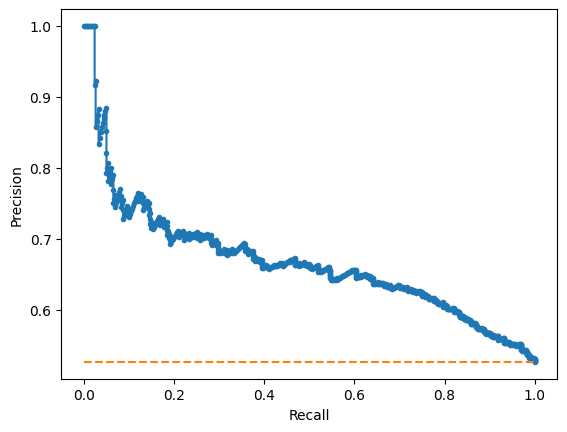

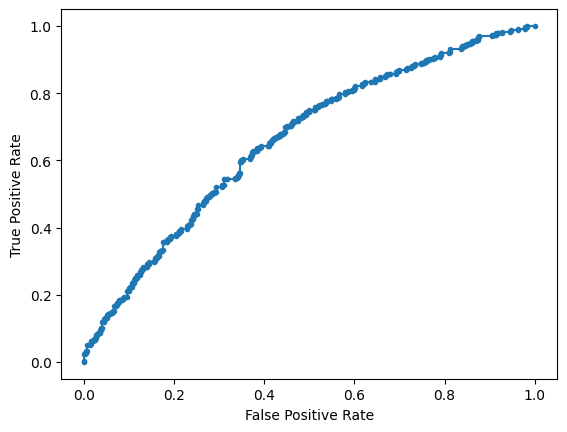

Accuracy: 61.49% Precision: 59.75% Recall: 82.31%
F1: 69.24% MCC: 0.2311
AUPRC: 66.75% AUROC: 65.91%
 accuracy [61.49425287356321]
 precision [59.746434231378764]
 recall [82.31441048034934]
 F1 [69.23783287419651]
 MCC [0.23114288772670732]
 AUPRC [66.7466377312151]
 AUROC [65.9128969347522]
2023-04-04 13:47:04.472701

Training # 1 2
2023-04-04 13:47:04.473278
2023-04-04 13:47:04.473333
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-04-04 13:47:04.526641


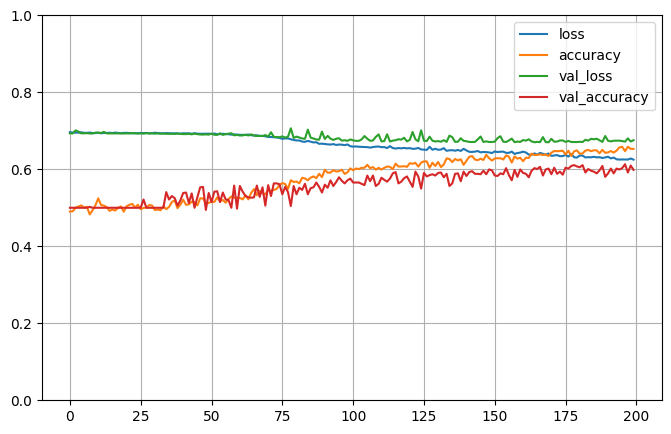


2023-04-04 13:47:58.802358

Testing # 1 2
2023-04-04 13:47:58.802491
2023-04-04 13:47:58.802533
PREDICT
2023-04-04 13:47:58.811711
Test 1:0 442:442 50.00%
Predict 1:0 341:543 38.57%
Test sizes (884, 1025) (884,)
Range of scores: 0.008636172 to 0.9802568
Score threshold 0.5
Confusion matrix
 [[315 127]
 [228 214]]
Normalized matrix
 [[0.35633484 0.14366516]
 [0.25791855 0.24208145]]


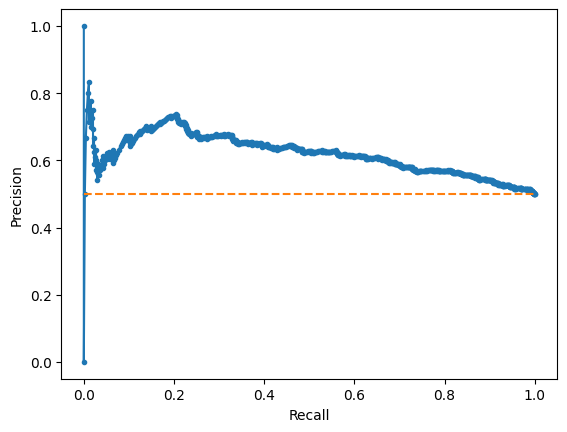

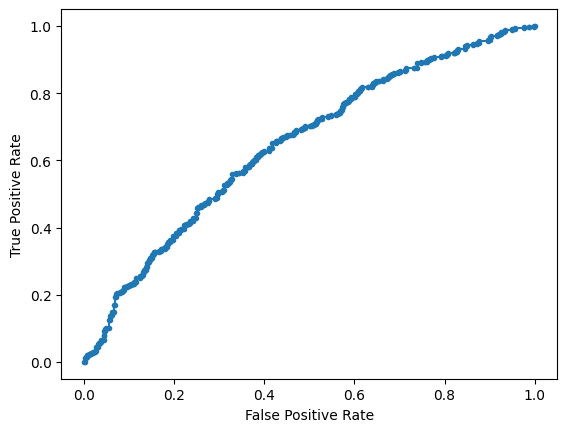

Accuracy: 59.84% Precision: 62.76% Recall: 48.42%
F1: 54.66% MCC: 0.2022
AUPRC: 61.82% AUROC: 64.73%
 accuracy [59.841628959276015]
 precision [62.75659824046921]
 recall [48.41628959276018]
 F1 [54.661558109833976]
 MCC [0.2021818417270836]
 AUPRC [61.824279750362706]
 AUROC [64.72840441432403]
2023-04-04 13:47:59.602784

Training # 1 3
2023-04-04 13:47:59.603984
2023-04-04 13:47:59.604189
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-04-04 13:47:59.657847


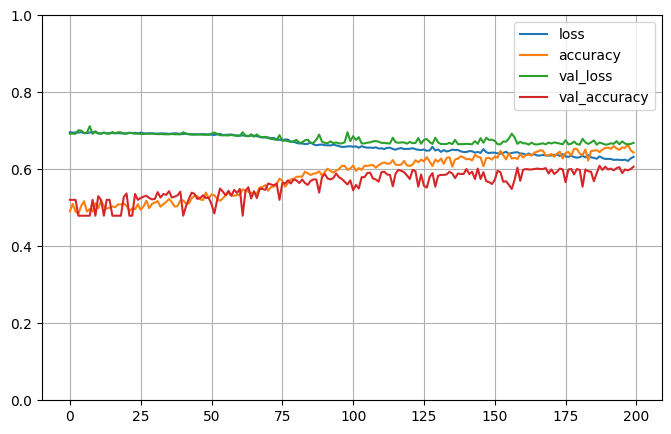


2023-04-04 13:48:54.492011

Testing # 1 3
2023-04-04 13:48:54.492492
2023-04-04 13:48:54.492524
PREDICT
2023-04-04 13:48:54.500419
Test 1:0 442:407 52.06%
Predict 1:0 610:239 71.85%
Test sizes (849, 1025) (849,)
Range of scores: 0.04272215 to 0.9729598
Score threshold 0.5
Confusion matrix
 [[156 251]
 [ 83 359]]
Normalized matrix
 [[0.18374558 0.29564193]
 [0.09776207 0.42285041]]


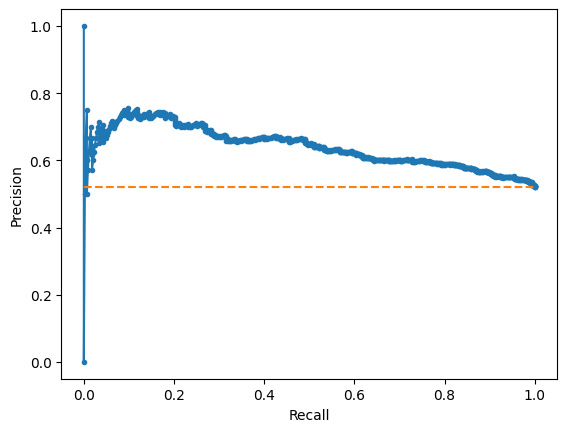

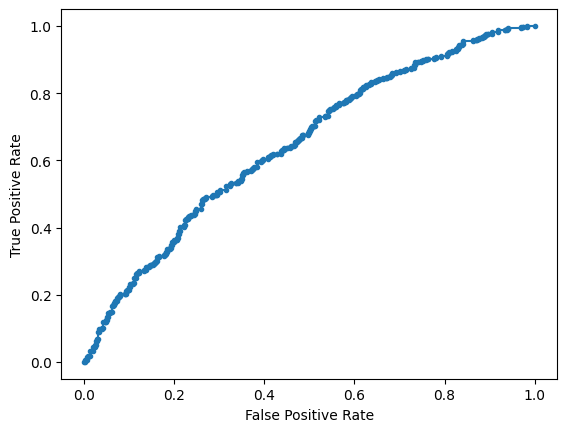

Accuracy: 60.66% Precision: 58.85% Recall: 81.22%
F1: 68.25% MCC: 0.2172
AUPRC: 63.92% AUROC: 64.61%
 accuracy [60.65959952885748]
 precision [58.852459016393446]
 recall [81.22171945701358]
 F1 [68.25095057034221]
 MCC [0.2171763397380818]
 AUPRC [63.92021600464835]
 AUROC [64.60582342935284]
2023-04-04 13:48:55.391775

Training # 1 4
2023-04-04 13:48:55.392947
2023-04-04 13:48:55.393006
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-04-04 13:48:55.444939


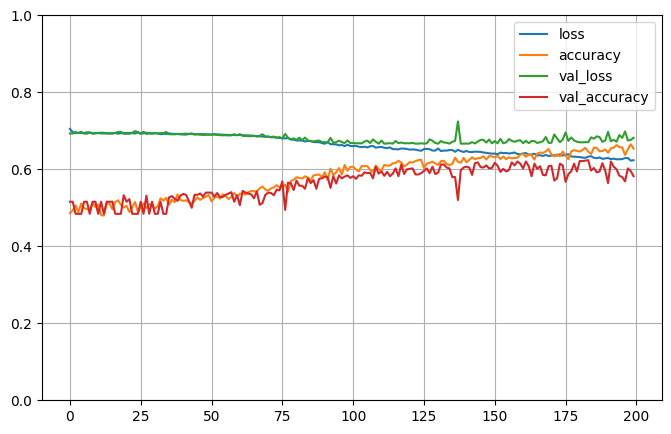


2023-04-04 13:49:49.407351

Testing # 1 4
2023-04-04 13:49:49.407747
2023-04-04 13:49:49.407779
PREDICT
2023-04-04 13:49:49.412656
Test 1:0 459:431 51.57%
Predict 1:0 679:211 76.29%
Test sizes (890, 1025) (890,)
Range of scores: 0.0112146195 to 0.97501546
Score threshold 0.5
Confusion matrix
 [[135 296]
 [ 76 383]]
Normalized matrix
 [[0.15168539 0.33258427]
 [0.08539326 0.43033708]]


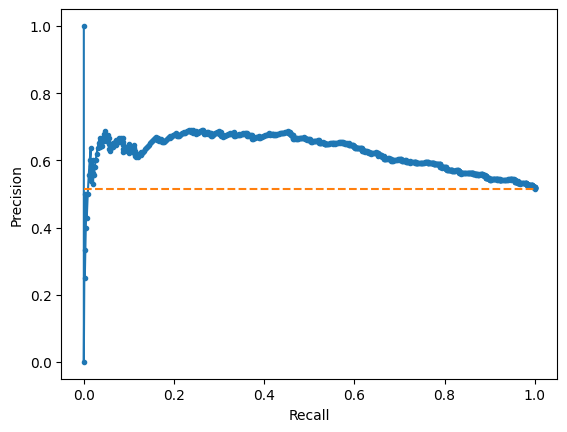

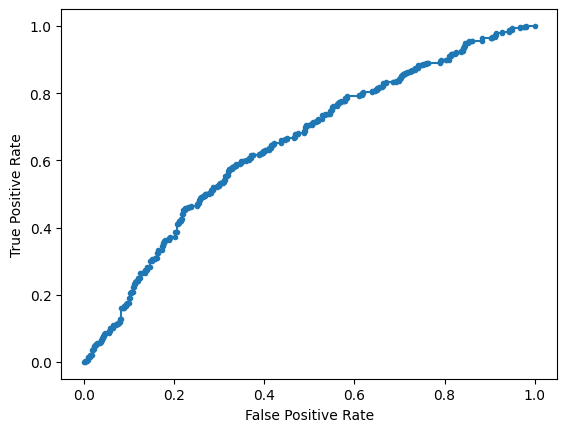

Accuracy: 58.20% Precision: 56.41% Recall: 83.44%
F1: 67.31% MCC: 0.1735
AUPRC: 62.51% AUROC: 64.76%
 accuracy [58.20224719101124]
 precision [56.40648011782032]
 recall [83.44226579520696]
 F1 [67.31107205623901]
 MCC [0.17349844873309053]
 AUPRC [62.50973529131832]
 AUROC [64.75946398151939]
2023-04-04 13:49:50.255813

Training # 1 5
2023-04-04 13:49:50.257288
2023-04-04 13:49:50.257344
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-04-04 13:49:50.314197


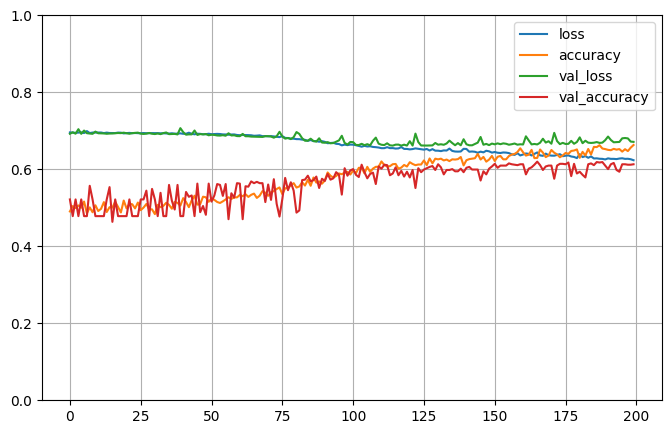


2023-04-04 13:51:13.083046

Testing # 1 5
2023-04-04 13:51:13.083528
2023-04-04 13:51:13.083561
PREDICT
2023-04-04 13:51:13.088435
Test 1:0 457:419 52.17%
Predict 1:0 454:422 51.83%
Test sizes (876, 1025) (876,)
Range of scores: 0.017440751 to 0.97866225
Score threshold 0.5
Confusion matrix
 [[251 168]
 [171 286]]
Normalized matrix
 [[0.28652968 0.19178082]
 [0.19520548 0.32648402]]


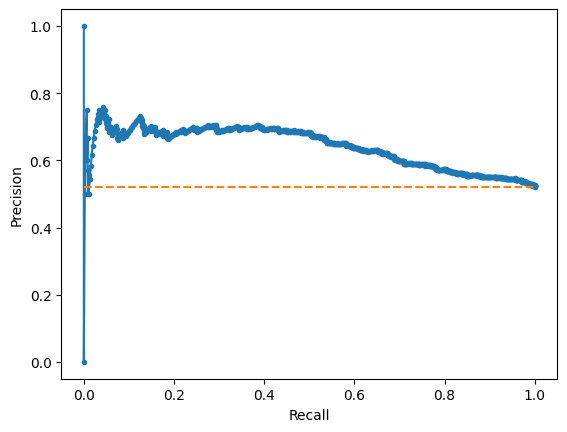

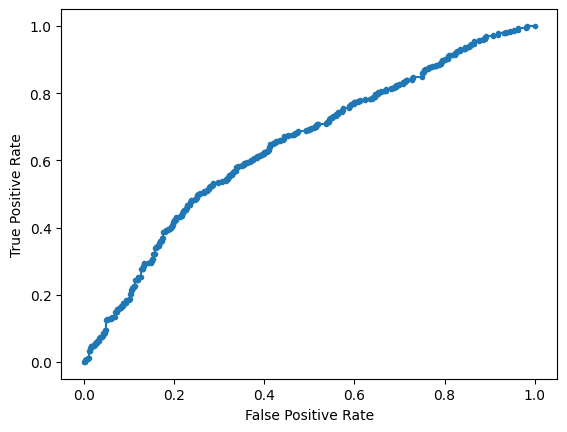

Accuracy: 61.30% Precision: 63.00% Recall: 62.58%
F1: 62.79% MCC: 0.2248
AUPRC: 64.04% AUROC: 64.54%
 accuracy [61.3013698630137]
 precision [62.99559471365639]
 recall [62.58205689277899]
 F1 [62.788144895718986]
 MCC [0.2248042875472101]
 AUPRC [64.03713063278317]
 AUROC [64.5441109654643]
2023-04-04 13:51:13.966956

Training # 2 1
2023-04-04 13:51:13.968102
2023-04-04 13:51:13.968340
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-04-04 13:51:14.016311


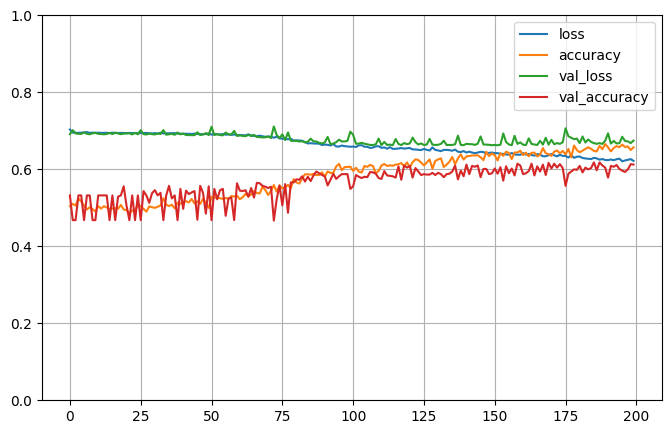


2023-04-04 13:52:08.035196

Testing # 2 1
2023-04-04 13:52:08.038331
2023-04-04 13:52:08.038631
PREDICT
2023-04-04 13:52:08.043910
Test 1:0 472:415 53.21%
Predict 1:0 380:507 42.84%
Test sizes (887, 1025) (887,)
Range of scores: 0.024766175 to 0.98218256
Score threshold 0.5
Confusion matrix
 [[289 126]
 [218 254]]
Normalized matrix
 [[0.32581736 0.14205186]
 [0.24577227 0.28635851]]


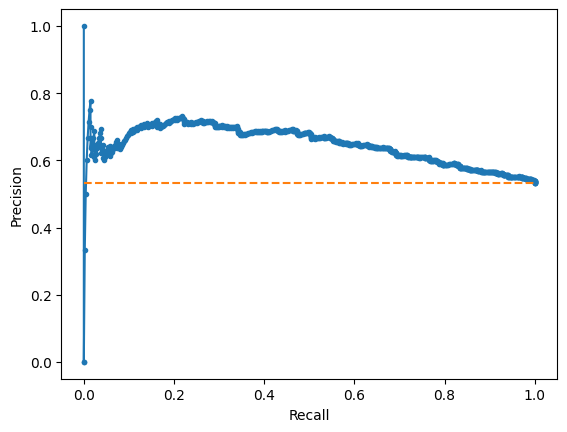

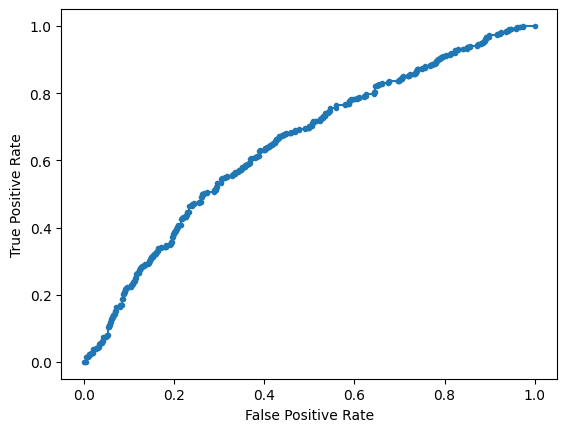

Accuracy: 61.22% Precision: 66.84% Recall: 53.81%
F1: 59.62% MCC: 0.2365
AUPRC: 64.58% AUROC: 64.83%
 accuracy [61.21758737316798]
 precision [66.84210526315789]
 recall [53.813559322033896]
 F1 [59.624413145539904]
 MCC [0.23647283486105034]
 AUPRC [64.57961128601373]
 AUROC [64.82744537471922]
2023-04-04 13:52:08.855931

Training # 2 2
2023-04-04 13:52:08.856907
2023-04-04 13:52:08.856966
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-04-04 13:52:08.912058


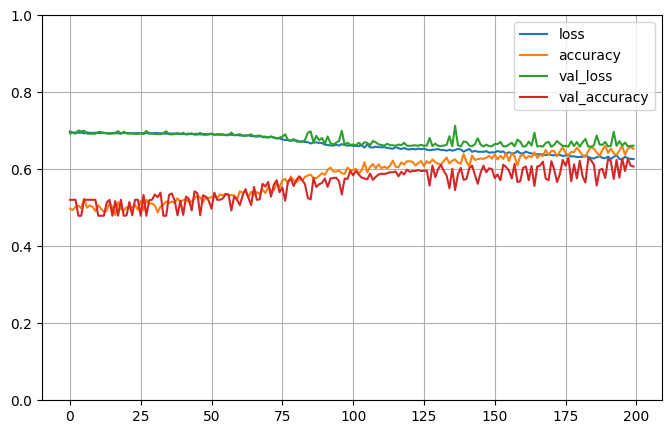


2023-04-04 13:53:31.740090

Testing # 2 2
2023-04-04 13:53:31.740250
2023-04-04 13:53:31.740334
PREDICT
2023-04-04 13:53:31.747482
Test 1:0 452:416 52.07%
Predict 1:0 591:277 68.09%
Test sizes (868, 1025) (868,)
Range of scores: 0.0152225075 to 0.957345
Score threshold 0.5
Confusion matrix
 [[176 240]
 [101 351]]
Normalized matrix
 [[0.20276498 0.2764977 ]
 [0.11635945 0.40437788]]


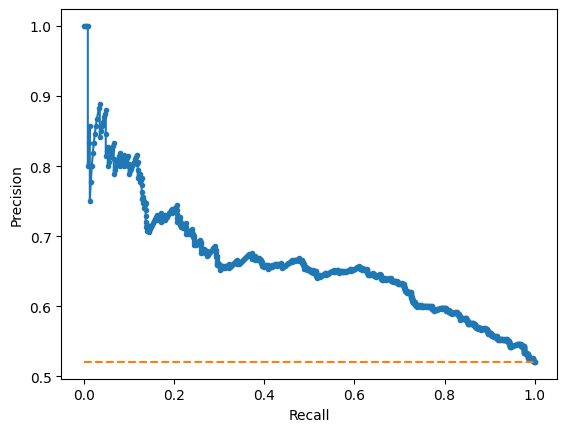

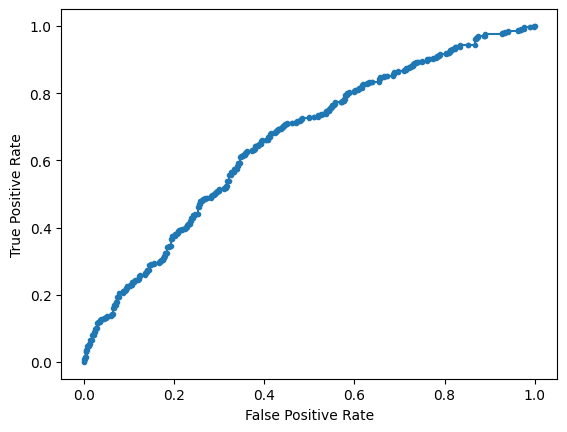

Accuracy: 60.71% Precision: 59.39% Recall: 77.65%
F1: 67.31% MCC: 0.2139
AUPRC: 66.31% AUROC: 65.86%
 accuracy [60.71428571428571]
 precision [59.390862944162436]
 recall [77.65486725663717]
 F1 [67.3058485139022]
 MCC [0.21394319772386702]
 AUPRC [66.31100030475862]
 AUROC [65.85581177671887]
2023-04-04 13:53:32.620318

Training # 2 3
2023-04-04 13:53:32.622109
2023-04-04 13:53:32.622181
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-04-04 13:53:32.690938


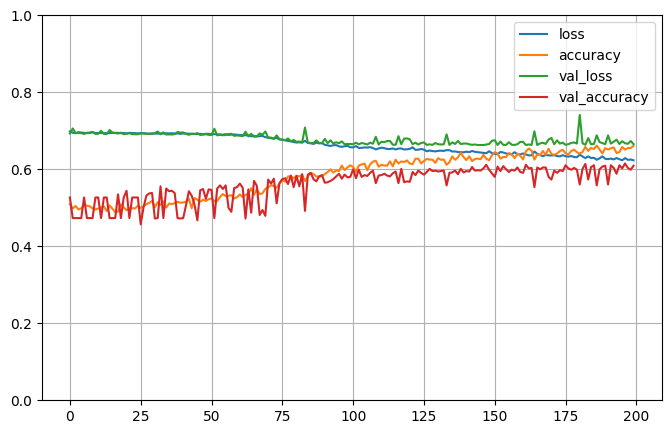


2023-04-04 13:54:55.502646

Testing # 2 3
2023-04-04 13:54:55.502760
2023-04-04 13:54:55.502818
PREDICT
2023-04-04 13:54:55.517237
Test 1:0 453:407 52.67%
Predict 1:0 541:319 62.91%
Test sizes (860, 1025) (860,)
Range of scores: 0.003749191 to 0.94568527
Score threshold 0.5
Confusion matrix
 [[195 212]
 [124 329]]
Normalized matrix
 [[0.22674419 0.24651163]
 [0.14418605 0.38255814]]


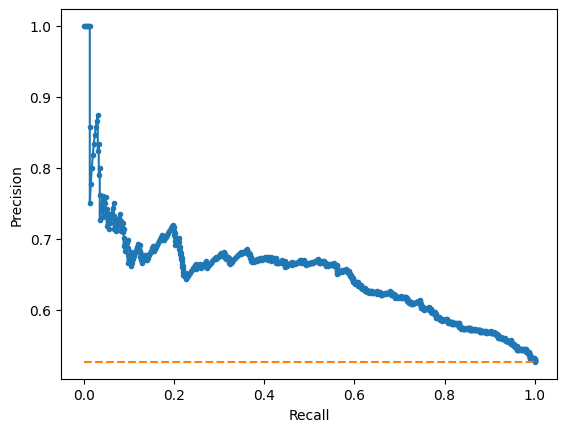

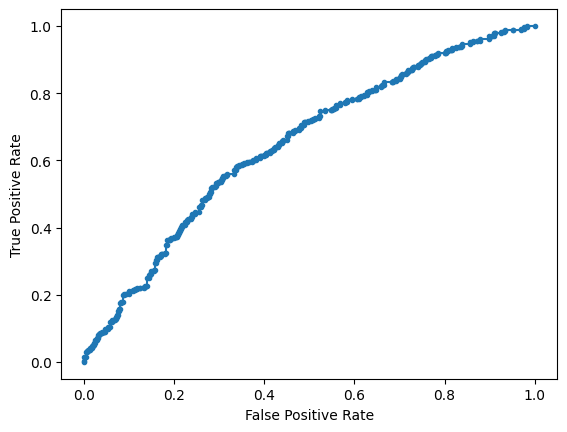

Accuracy: 60.93% Precision: 60.81% Recall: 72.63%
F1: 66.20% MCC: 0.2123
AUPRC: 64.97% AUROC: 64.70%
 accuracy [60.93023255813953]
 precision [60.81330868761553]
 recall [72.62693156732892]
 F1 [66.19718309859155]
 MCC [0.21228564122982801]
 AUPRC [64.96840912969488]
 AUROC [64.69997993176801]
2023-04-04 13:54:56.407269

Training # 2 4
2023-04-04 13:54:56.408344
2023-04-04 13:54:56.409138
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-04-04 13:54:56.469906


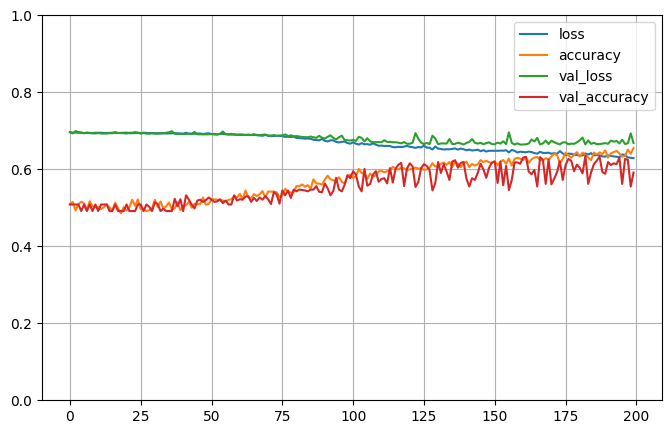


2023-04-04 13:55:55.186989

Testing # 2 4
2023-04-04 13:55:55.188434
2023-04-04 13:55:55.188793
PREDICT
2023-04-04 13:55:55.194194
Test 1:0 432:447 49.15%
Predict 1:0 513:366 58.36%
Test sizes (879, 1025) (879,)
Range of scores: 0.02412151 to 0.9580239
Score threshold 0.5
Confusion matrix
 [[227 220]
 [139 293]]
Normalized matrix
 [[0.25824801 0.25028441]
 [0.15813424 0.33333333]]


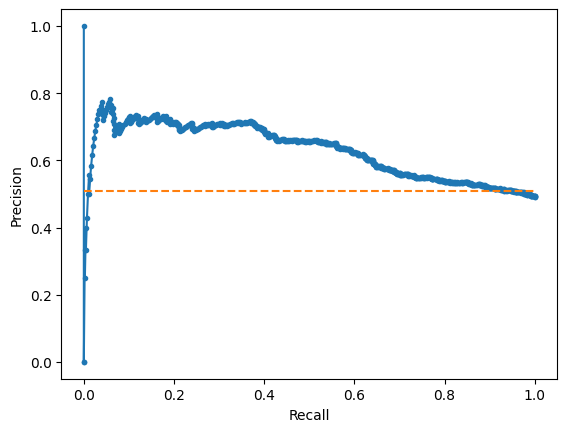

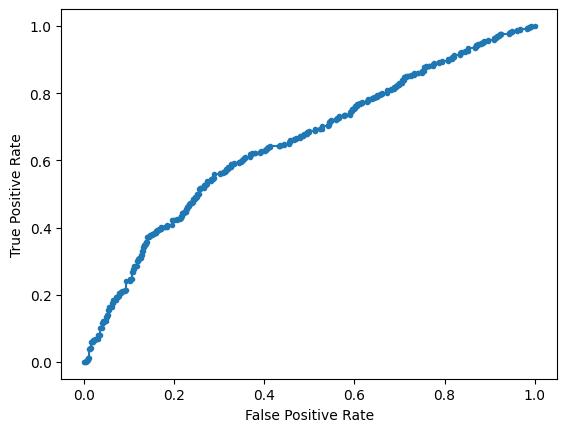

Accuracy: 59.16% Precision: 57.12% Recall: 67.82%
F1: 62.01% MCC: 0.1887
AUPRC: 62.85% AUROC: 65.12%
 accuracy [59.15813424345847]
 precision [57.1150097465887]
 recall [67.82407407407408]
 F1 [62.010582010582006]
 MCC [0.18870110531506123]
 AUPRC [62.850569866930925]
 AUROC [65.1208675118071]
2023-04-04 13:55:56.183940

Training # 2 5
2023-04-04 13:55:56.185638
2023-04-04 13:55:56.185691
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-04-04 13:55:56.253336


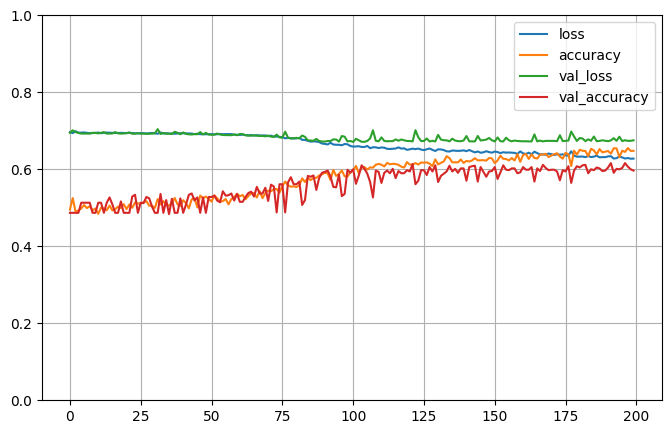


2023-04-04 13:56:52.955389

Testing # 2 5
2023-04-04 13:56:52.955757
2023-04-04 13:56:52.955801
PREDICT
2023-04-04 13:56:52.965301
Test 1:0 449:426 51.31%
Predict 1:0 382:493 43.66%
Test sizes (875, 1025) (875,)
Range of scores: 0.035635393 to 0.9761063
Score threshold 0.5
Confusion matrix
 [[283 143]
 [210 239]]
Normalized matrix
 [[0.32342857 0.16342857]
 [0.24       0.27314286]]


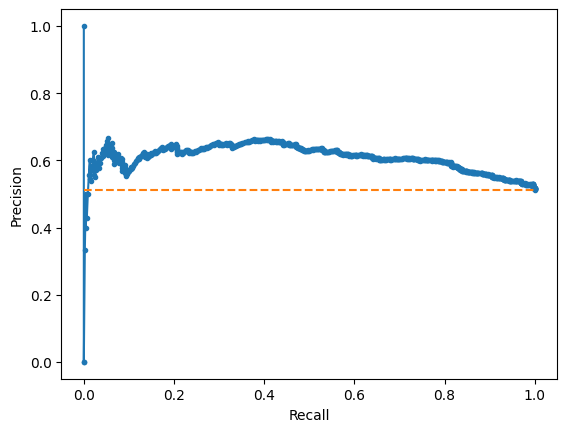

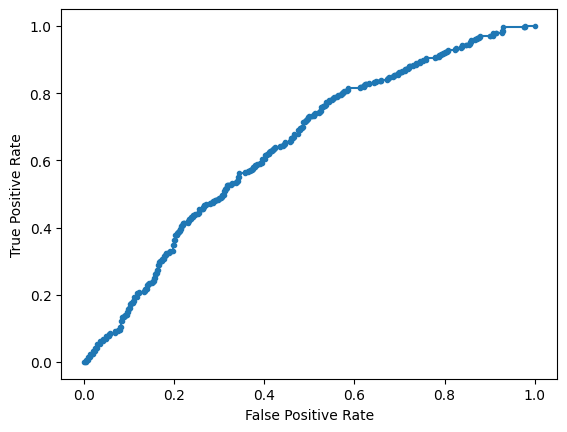

Accuracy: 59.66% Precision: 62.57% Recall: 53.23%
F1: 57.52% MCC: 0.1981
AUPRC: 60.76% AUROC: 64.16%
 accuracy [59.65714285714285]
 precision [62.56544502617801]
 recall [53.229398663697104]
 F1 [57.52105896510229]
 MCC [0.19814612289206135]
 AUPRC [60.757059097030265]
 AUROC [64.16240576345974]
2023-04-04 13:56:53.444334


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 60.32% std 1.07
 precision mean 60.75% std 3.13
 recall mean 68.31% std 13.18
 F1 mean 63.49% std 4.98
 MCC mean 0.21% std 0.02
 AUPRC mean 63.85% std 1.91
 AUROC mean 64.92% std 0.56
 accuracy [[61.49425287356321], [59.841628959276015], [60.65959952885748], [58.20224719101124], [61.3013698630137], [61.21758737316798], [60.71428571428571], [60.93023255813953], [59.15813424345847], [59.65714285714285]]
 precision [[59.746434231378764], [62.75659824046921], [58.852459016393446], [56.40648011782032], [62.99559471365639], [66.84210526315789], [59.390862944162436], [60.81330868761553], [57.1150097465887], [62.56544502617801]]
 recall [[82.31441048034934], [48.41628959276018], [81.22171945701358], [83.44226579520696], [62.58205689277899], [53.813559322033896], [77.65486725663717], [72.62693156732892], [67.82407407407408], [53.229398663697104]]
 F1 [[69.23783287419651], [54.661558109833976], [68.25095057034221], [67.31107205623901], [62.788144895718986], [59.624413145539904], [